# Data Cleaning - Gout Emergency Department Chief Complaint
 ### The goal of this project is the answer the question:   </np><i>Is the patient potentially suffering from Gout?</i> 

## Scope

The scope of this project is corpora from the Deep South.  The demographics of the population from which they were derived are 54% female, and 46% male, 55% Black, 40% White, 2% Hispanic, and 1% Asian. Age distribution was 5% between ages 1-20 years, 35% between ages 21-40 years, 35% between ages 41-60 years, 20% between ages 61-80 years, and 5% between ages 81-100 years.

## Data

The data is extracted in csv format from the MIMIC-III (Medical Information Mart for Intensive Care III) database.  Details can be found at https://physionet.org/content/emer-complaint-gout/1.0/.   Acces to the database may be requested at (https://mimic.physionet.org/gettingstarted/access/). 

The data provided by the MIMIC database consists of 2 corpora of free text collected by the triage nurse and recorded as the "Chief Complaint".  Each complaint contains up to 282 characters in length and was collected from 2019 to 2020 at an academic medical center in the Deep South.  The 2019 corpora, "GOUT-CC-2019-CORPUS", consists of 300 chief complaints selected by the presence of the keyword "gout". The 2020 corpora, "GOUT-CC-2020-CORPUS" contains 8037 chief complaints collected from a single month in 2020. The chief complaints included in both corpora were selected based on the presence of the keyword "gout".

**Import Data**

In [1]:
import pandas as pd

syn2019 = pd.read_csv('Data/GOUT-CC-2019-CORPUS-SYNTHETIC.csv')
syn2020 = pd.read_csv('Data/GOUT-CC-2020-CORPUS-SYNTHETIC.csv')


**Data Description**
* 2 csv files
    * 2019 : 300 records
    * 2020 : 8037 records
    * Identical layouts and formats: all text, 3 columns
    <br><br>
* 3 Columns:  ["Chief Complaint", "Predict", "Consensus"]
    * <b>Chief Complaint:</b> 
        * text format
        * up to 282 Chars
        * nurse recorded patient complaint
    * <b>Predict:</b> 
        * text format
        * single char ('-','U','Y','N')
        * prediction of Gout by the ER Physician
    * <b>Consensus:</b> 
        * textformat
        * single char ('-','U','Y','N')
        * determination of Gout by the Rhuematologist
    <br>
* 
          - : Null
          U : Unknonw
          Y : Yes
          N : Gout

## Format Data

In [2]:
print(syn2019.head())

                                     Chief Complaint Predict Consensus
0  "been feeling bad" last 2 weeks & switched BP ...       N         -
1  "can't walk", reports onset at 0830 am. orient...       Y         N
2  "dehydration" Chest hurts, hips hurt, cramps P...       Y         Y
3  "gout flare up" L arm swelling x 1 week. denie...       Y         Y
4  "heart racing,"dyspnea, and orthopnea that has...       N         -


In [3]:
print(syn2020.head())

                                     Chief Complaint Predict Consensus
0  "I dont know whats going on with my head, its ...       N         -
1  "i've been depressed for a few weeks now, i'm ...       N         -
2  Altercation while making arrest, c/o R hand pa...       N         N
3  Cut on L upper thigh wtih saw. Bleeding contro...       N         N
4   Dysuria x1 week. hx: hysterectomy, gerd, bipolar       N         -


**Combine the 2 files**

In [4]:
# Combine the files into 1 dataframe
df = pd.concat([syn2019, syn2020], axis=0).reset_index(drop=True)
print(df.shape)

(8437, 3)


**Review records for null value '-' in the files**

In [5]:
print(df['Predict'].value_counts(sort=False))

U     156
N    8168
-       2
Y     111
Name: Predict, dtype: int64


In [6]:
print(df['Consensus'].value_counts(sort=False))

U      16
N     350
-    7976
Y      95
Name: Consensus, dtype: int64


**Remove records that contain null's '-' in both potential target values: Predict and Consensus.**

In [7]:
print( df[(df.Consensus == '-') & (df.Predict == '-')])

                                        Chief Complaint Predict Consensus
7799  Right lower back pain that radiates down leg t...       -         -
7857  pain to posterior upper leg x 3 days, seen at ...       -         -


## Clean Data

   * Remove records that contain null values in both of the Predict and Consensus columns.
   * Fill Consensus null values ( - ) with Predict values
   * Change all chars to lowercase
   * Remove punctuation
   * Remove words containing numbers

**Remove records with double 'null' values, records with '-' in both Consensus and Predict.**

In [8]:
df = df[(df.Consensus != '-') | (df.Predict != '-')]
print(df.shape)

(8435, 3)


The predict column contains a value agreed upon by a panel of physicians while the consensus is the 'Rheumatologist findings, patients who did require follow-up with a Rhuematologist will be included using the predict values.

**Fill null values in consensus with predict value**

In [9]:
for a in df['Consensus']:
    if a == '-':
        df['Consensus'] = df['Predict']

In [10]:
print(df['Consensus'].value_counts(sort=False))

U     156
N    8168
Y     111
Name: Consensus, dtype: int64


**Convert to lowercase, remove punctuation and words containing numbers**

In [11]:
import re
import string

def clean_text(text):
    text=text.lower()                                                 # change all chars to lowercase    
    text=re.sub('[%s]' % re.escape(string.punctuation), '', text)     # remove punctuations
    text=re.sub("(\\d|\\W)+"," ",text)                                # remove numbers
    return text


df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x:clean_text(x))
df

,Chief Complaint,Predict,Consensus
0,been feeling bad last weeks switched bp medica...,N,N
1,cant walk reports onset at am oriented x aorti...,Y,Y
2,dehydration chest hurts hips hurt cramps pmh h...,Y,Y
3,gout flare up l arm swelling x week denies any...,Y,Y
4,heart racingdyspnea and orthopnea that has bee...,N,N
...,...,...,...
8432,stepped on a nail at home with right foot pain...,N,N
8433,i was having a breakdown rt stress and depres...,N,N
8434,i tried to jump in front of a car pt states sh...,N,N
8435,abdominal pain x week denies pmh,N,N


## Process Raw Data
* Tokenize
* Remove Stop Words
* Lemmitization
* Convert to Matix format

**Perform tokenization using nltk package**

In [12]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")

In [13]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x: tokenizer.tokenize(x.lower()))

**SPACY selected for STOPWORD removal**

In [14]:
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS
print(len(STOP_WORDS))

326


**Additional stopwords added during preprocessing**

In [15]:
STOP_WORDS |= {'co', 'denies', 'htn', 'hx','pt','pmh', 'pmhx', 'states','days'}

In [16]:
print(len(STOP_WORDS))

335


**Remove Stopwords**

In [17]:
def remove_stopwords(text):
    words = [w for w in text if w not in STOP_WORDS]
    return words

In [18]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x : remove_stopwords(x))
df['Chief Complaint'].head()

0    [feeling, bad, weeks, switched, bp, medication...
1    [cant, walk, reports, onset, oriented, x, aort...
2    [dehydration, chest, hurts, hips, hurt, cramps...
3             [gout, flare, l, arm, swelling, x, week]
4    [heart, racingdyspnea, orthopnea, getting, wor...
Name: Chief Complaint, dtype: object

**Perform lemmatization with nltk package**

In [19]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [20]:
df['Chief Complaint'].apply(lambda x: word_lemmatizer(x))

0       [feeling, bad, week, switched, bp, medication,...
1       [cant, walk, report, onset, oriented, x, aorti...
2       [dehydration, chest, hurt, hip, hurt, cramp, h...
3                [gout, flare, l, arm, swelling, x, week]
4       [heart, racingdyspnea, orthopnea, getting, wor...
                              ...                        
8432    [stepped, nail, home, right, foot, painful, di...
8433          [having, breakdown, rt, stress, depression]
8434    [tried, jump, car, psych, med, arthritis, bipo...
8435                           [abdominal, pain, x, week]
8436    [rashsores, body, infection, ro, left, thumb, ...
Name: Chief Complaint, Length: 8435, dtype: object

**Drop Predict Column and rename Consensus as Target**

In [21]:
df = df.drop(columns=['Predict'])

In [22]:
df = df.rename(columns={'Chief Complaint': 'corpus', 'Consensus': 'target'})
df

,corpus,target
0,"[feeling, bad, weeks, switched, bp, medication...",N
1,"[cant, walk, reports, onset, oriented, x, aort...",Y
2,"[dehydration, chest, hurts, hips, hurt, cramps...",Y
3,"[gout, flare, l, arm, swelling, x, week]",Y
4,"[heart, racingdyspnea, orthopnea, getting, wor...",N
...,...,...
8432,"[stepped, nail, home, right, foot, painful, di...",N
8433,"[having, breakdown, rt, stress, depression]",N
8434,"[tried, jump, car, psych, meds, arthritis, bip...",N
8435,"[abdominal, pain, x, week]",N


## Additional Formatting and Initial Analysis

**Create dataframes for analysis containing only patients positive for gout (target=y) and patients without gout as a diagnosis**

In [23]:
yes_gout = df.loc[df['target'] == 'Y']

In [24]:
no_gout = df.loc[df['target'] == 'N']

**Convert all data to Document-Term Matrix format**

**COMPLETE DATASET**

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(df['corpus'].astype(str))
vectored_data = pd.DataFrame.sparse.from_spmatrix(vectorized, columns=vectorizer.get_feature_names())

In [26]:
allData = vectored_data.sum(axis=0)
allData = allData.sort_values(ascending=False).head(10)
allData

pain       4658
left       1149
right      1009
chest       716
ago         707
dm          705
weeks       677
week        644
lower       633
reports     624
dtype: int64

<AxesSubplot:>

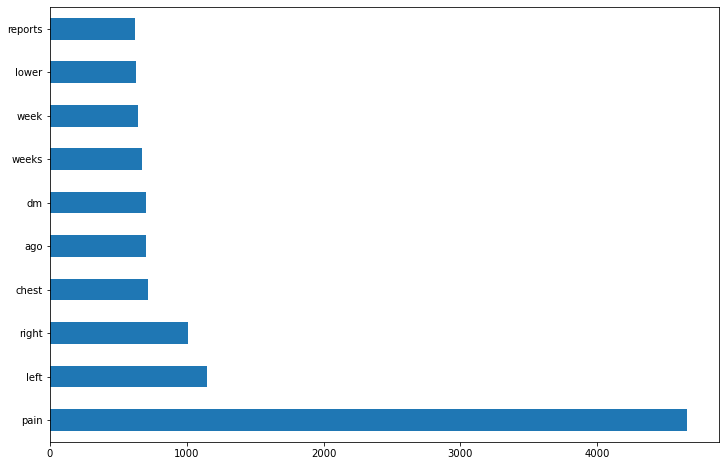

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
allData.plot.barh()

**DATA FOR GOUT-POSITIVE ONLY**

In [28]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(yes_gout['corpus'].astype(str))
gout_data = pd.DataFrame.sparse.from_spmatrix(vectorized, columns=vectorizer.get_feature_names())

In [29]:
gout_pos = gout_data.sum(axis=0)
gout_pos = gout_pos.sort_values(ascending=False).head(10)
gout_pos

gout        149
pain        105
knee         29
swelling     29
foot         26
left         24
dm           21
right        17
flare        15
week         15
dtype: int64

<AxesSubplot:>

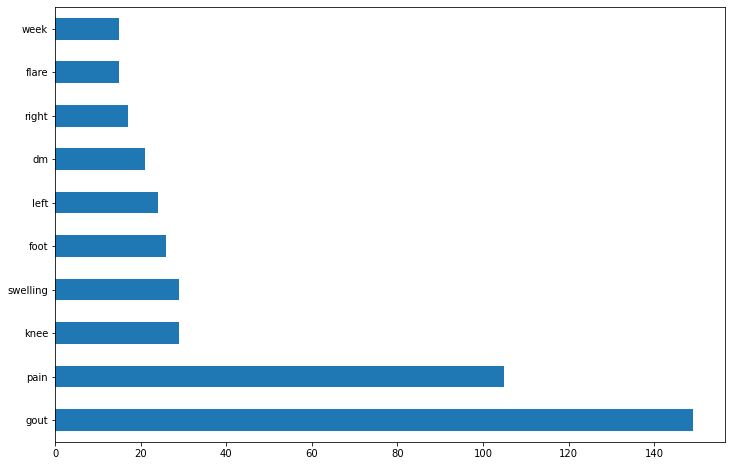

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
gout_pos.plot.barh()

**DATA FOR GOUT-NEGATIVE ONLY**

In [31]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(no_gout['corpus'].astype(str))
nogout_data = pd.DataFrame.sparse.from_spmatrix(vectorized, columns=vectorizer.get_feature_names())

In [32]:
gout_neg = nogout_data.sum(axis=0)
gout_neg = gout_neg.sort_values(ascending=False).head(10)
gout_neg

pain     4395
left     1095
right     949
chest     707
ago       690
dm        662
weeks     644
cough     621
week      620
lower     617
dtype: int64

<AxesSubplot:>

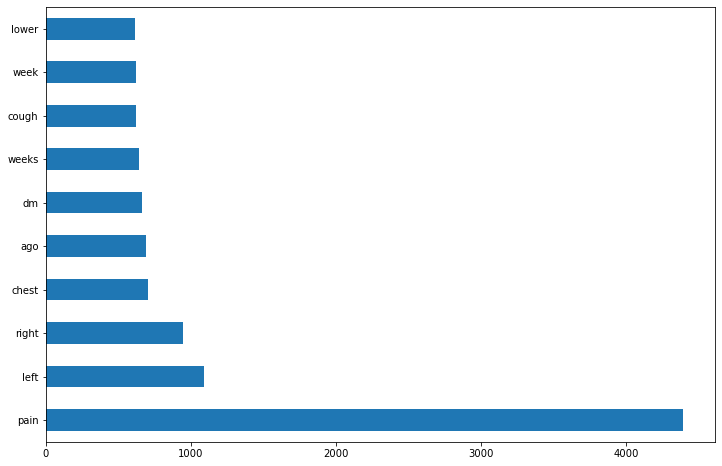

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
gout_neg.plot.barh()

**Looking at the most common words in gout and nongout patients, several words show up that can be removed to improve results:  'co', 'denies', 'htn', 'hx', and 'pt', show up in both positive and negative target values.  In addition 'pmh', 'pmhx', 'states', 'days' can be added to the stopword list**